In [73]:
from __future__ import division

import os
import numpy.ma as ma
import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlats 1p0'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20151108/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20151108/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = 'AnaK_1pa2'
all_side_files_red = 'DoubleSpec/20151108/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20151108/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20151108/red0093.fits') #use these to get targetid
#target[0].header
##################################################

# RED ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


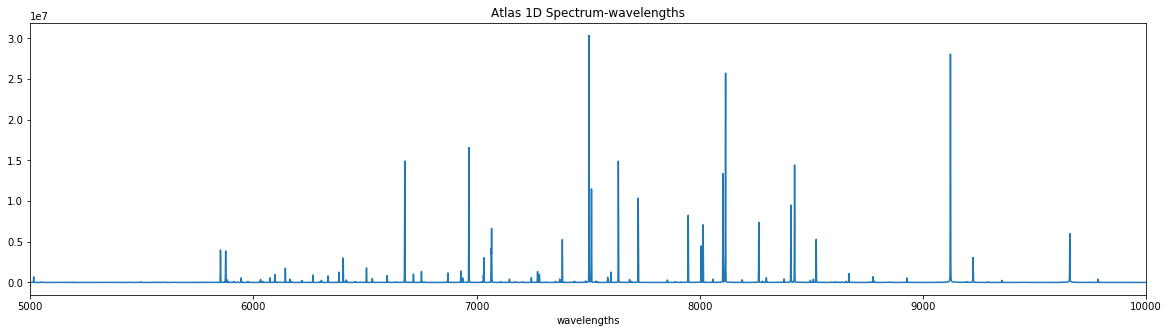

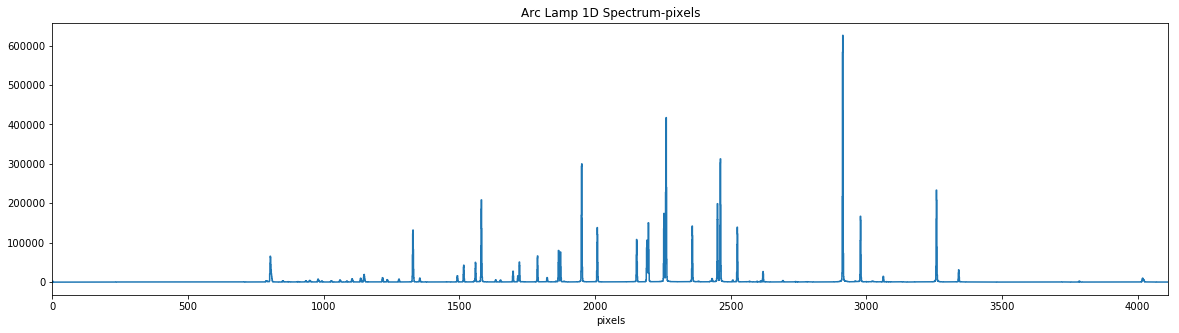

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

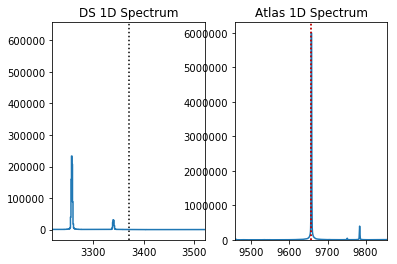

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [2911,2260,1949,3256]
atlas_lines = [9122.9674,8115.311,7635.106,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line NeI at wl=7535.7739: "Guessed line's peak to base ratio is 2.7561203378117187, which is less than 10"
Failed to find line NeI at wl=7544.0443: "Guessed line's peak to base ratio is 1.6876625563580907, which is less than 10"
Failed to find line KrI at wl=7587.413: "Tried to find peak at 1919.5304291869293 but it's in a valley, not a peak"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.0468739447100008, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 1.0472317058839353, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0225861949867336, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Tried to find peak at 2092.8117537938547 but it's in a valley, not a peak"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.2213255083124788, which is less 

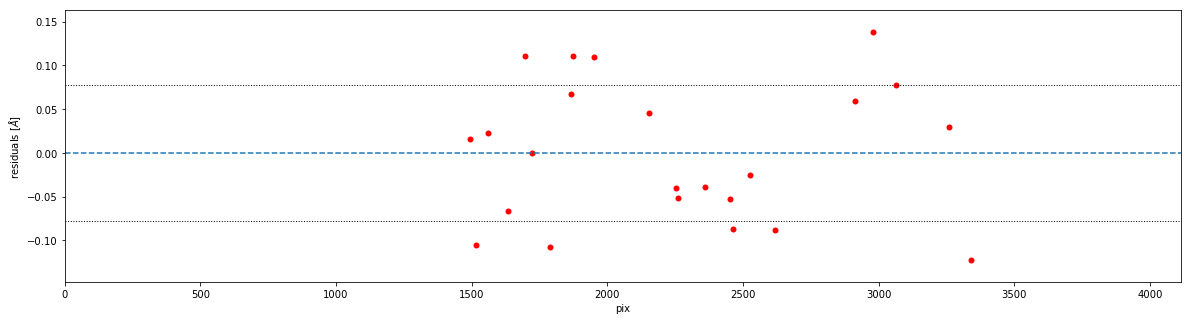

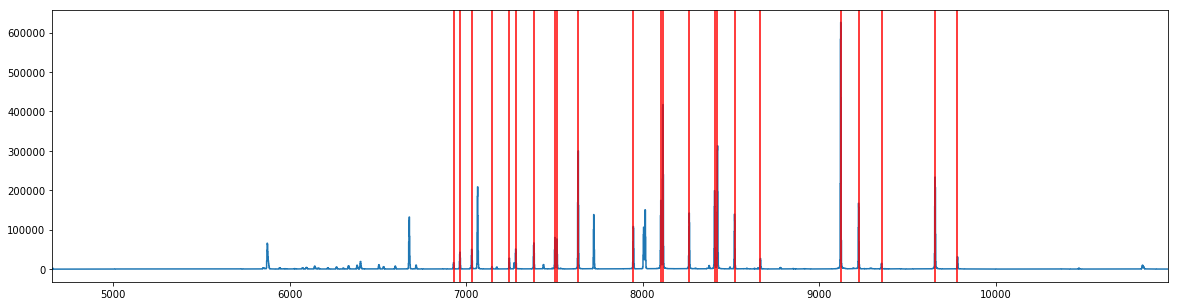

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

# Blue DS

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


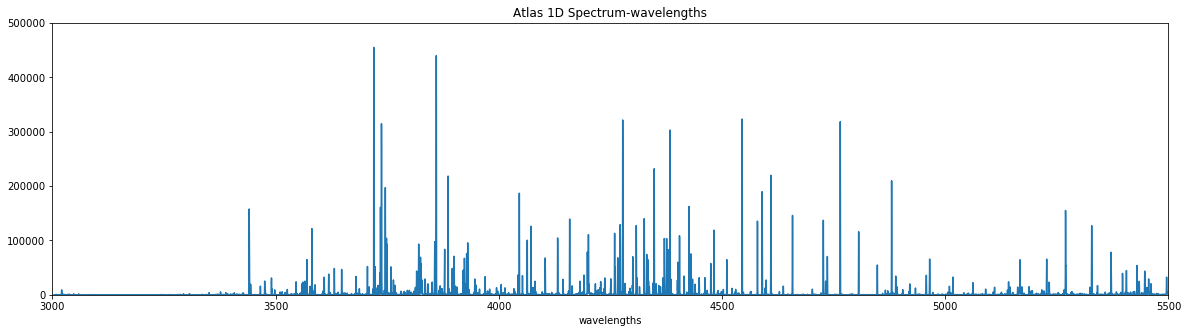

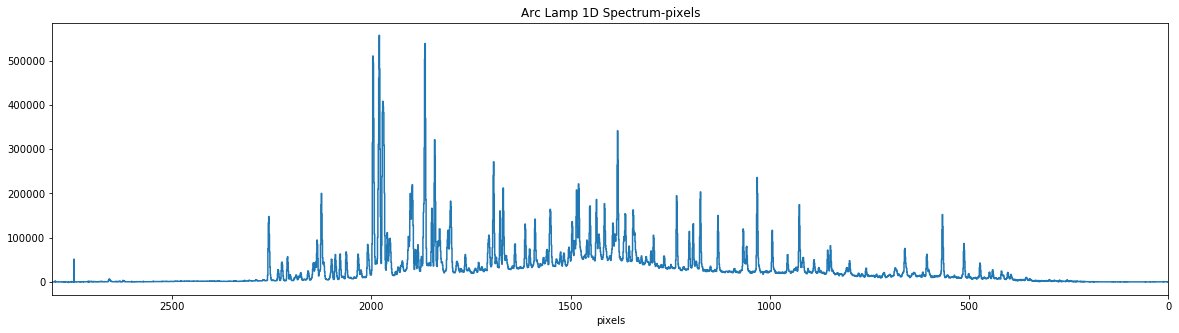

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

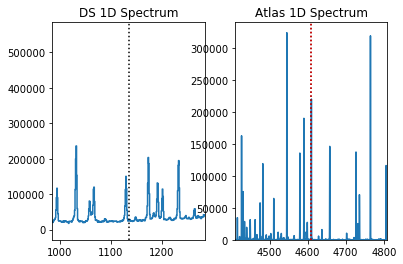

In [8]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [566,1031,2125,1995]
atlas_lines = [5269.5366,4764.8646,3581.1925,3719.9346]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 4.342313423417074, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 4.342313423417074, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 2.2865683295662476, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 4.1554542934611325, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.530395515752374, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.530395515752374, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.4249739084863702, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1708172486579012, which is 

Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 4.81366604098211, which is less than 5"
Found line ArII at wl=4042.8937
Clipped 0 lines
Found line ArI at wl=4044.4179
Clipped 0 lines
Found line FeI at wl=4045.813
Clipped 0 lines
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 1.7650387084642403, which is less than 5"
Found line FeI at wl=4063.5939
Clipped 0 lines
Found line ArII at wl=4103.9121
Clipped 0 lines
Failed to find line FeI at wl=4118.5442: "Guessed line's peak to base ratio is 1.766001548818575, which is less than 5"
Found line ArII at wl=4131.7235
Clipped 0 lines
Found line FeI at wl=4143.8688
Clipped 0 lines
Failed to find line ArI at wl=4158.5905: "Guessed line's peak to base ratio is 4.596396123703259, which is less than 5"
Failed to find line ArI at wl=4164.1795: "Guessed line's peak to base ratio is 1.317280634363201, which is less than 5"
Failed to find line FeI at wl=4198.3036: "Guessed line's peak to ba

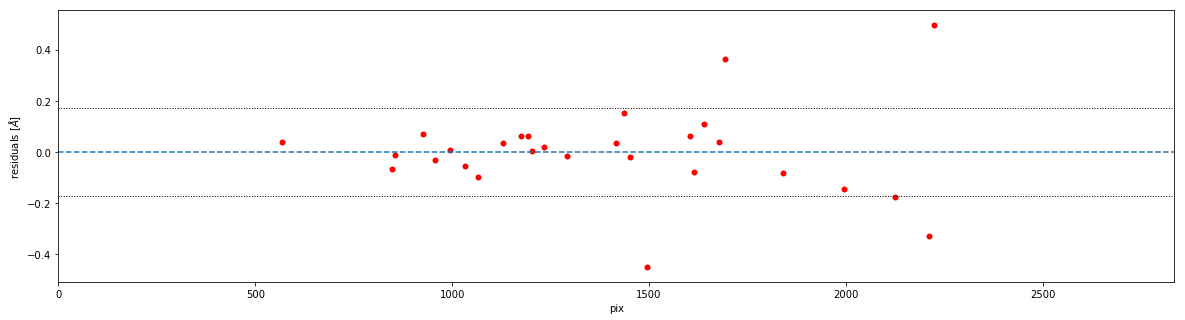

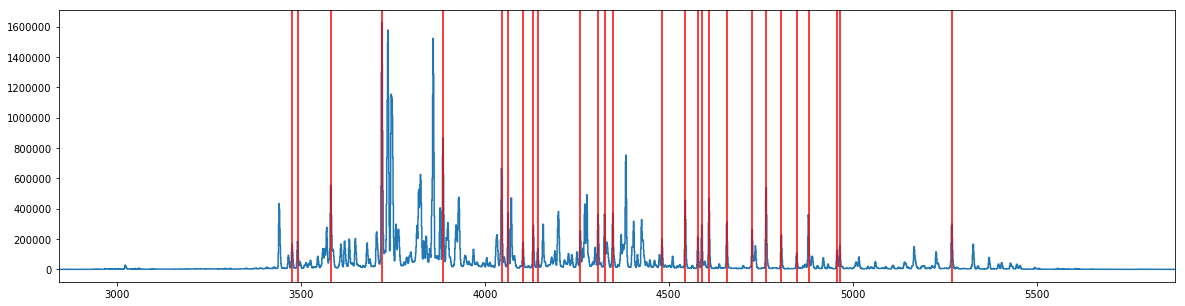

In [9]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

# Extracting 1D spectra (sky subtraction & stacking)


/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


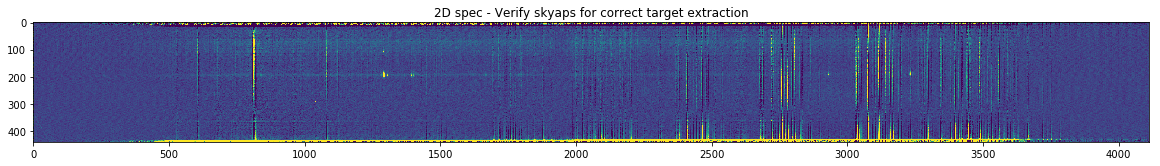

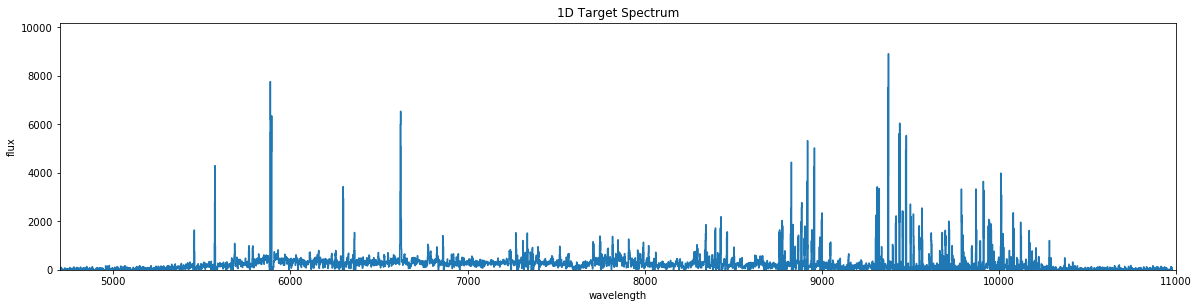

In [7]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red= [(20,30),(260,375)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (43,204)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??

#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for blueside
choose 1D target spec axis limits for blueside


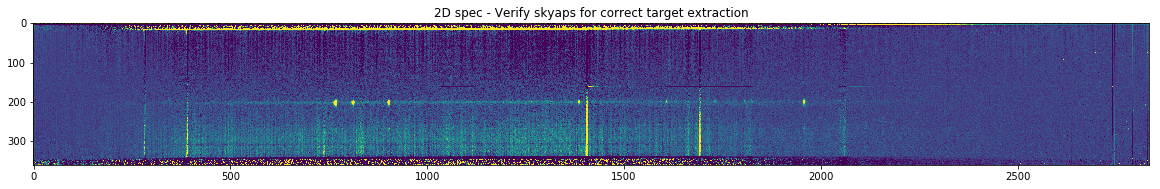

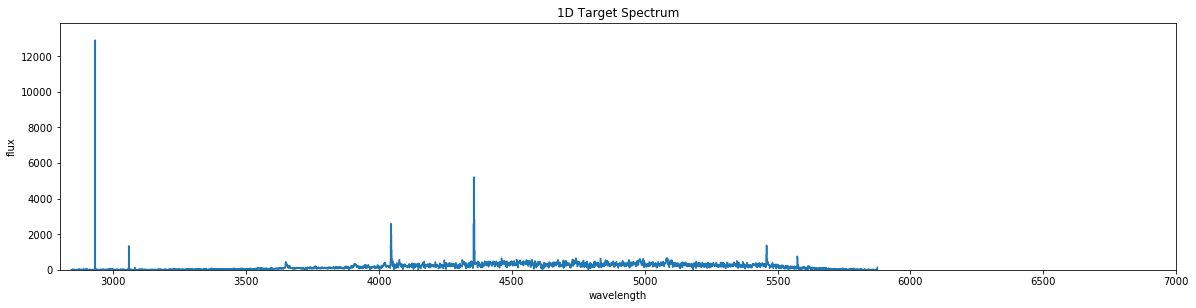

In [11]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(295,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

# Starting 2nd reduction technique for rot.curves


In [8]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red #avg(ok median) values from all images
best_emission_skyaps = skyaps_red #best sky aps
best_emission_model = model_red #best sky tilt estimation
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

# finding emission line centroids

In [19]:
#trying to understand where spec cut is in below cell

subimg2.data[0].shape

(4114,)

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (216, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


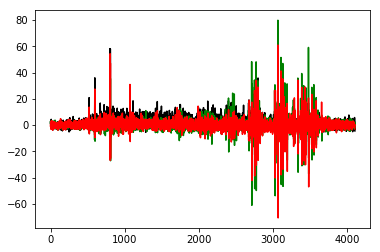

In [20]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(35,250) #target location 35,210 originally 43,204 in 1dspec,live values are a test
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[170],color='g')#near opposite galaxy edge
plt.plot(flux_data[105],color='r')#near galaxy center


#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

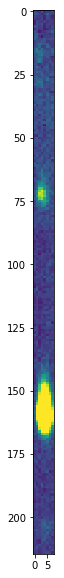

In [22]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################


testingthis=subimg2.data[35:250,1289:1297] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1289, 1297)
bestline_range_correction = (1279,1287) #includes shortened wl range
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

this shouldnt have changed in the spactial direction tho... they should both be flux_data_short, so whats going on?? Something in PART THREE aka the centroiding cell changes flux_dat_short


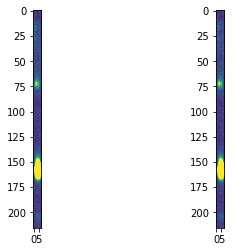

In [19]:
#my tests


#for reference
#flux_data_short = flux_data[:,1279:1287] #use 'bestline_range_correction' range
comparingthis = flux_data[:,1279:1287] #same def of flux_data_short from centroiding cell
#plt.figure(figsize=(10,10))
#plt.imshow(comparingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.imshow(flux_data_short,vmin=vmin,vmax=vmax)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(comparingthis,vmin=vmin,vmax=vmax)
ax1.imshow(flux_data_short,vmin=vmin,vmax=vmax)
print('this shouldnt have changed in the spactial direction tho... they should both be flux_data_short, so whats going on?? Something in PART THREE aka the centroiding cell changes flux_dat_short')

In [20]:
# my tests

(subimg2.data[::][0])
np.shape(subimg2.data[::][0])
np.shape(flux_data),np.shape(flux_data_short),np.shape(subimg2.data)

((216, 4104), (216, 8), (440, 4114))

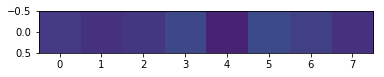

In [40]:
plt.imshow(flux_data[3:4,1279:1287],vmin=vmin,vmax=vmax)
print()

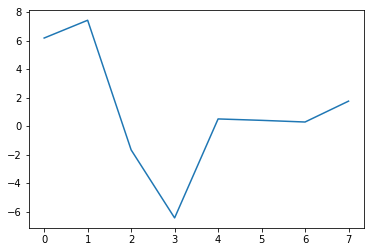

In [46]:
for row in flux_data[10:11,1279:1287]:
    targetx = np.arange(len(row))
    plt.plot(targetx,row)

badrow: 4 mean value: -1.51012193354 amplitude: 2.08965505812
badrow: 6 mean value: -1.11404740913 amplitude: 5.60060482219
badrow: 9 mean value: -0.275010987032 amplitude: 7.76110968682
badrow: 89 mean value: -3.49300850958 amplitude: 3.8114549432
badrow: 107 mean value: -20.5316609248 amplitude: 1.68442601852
badrow: 118 mean value: -19.8932798551 amplitude: 4.34596767353
badrow: 124 mean value: -5.30822725506 amplitude: 3.59142125876
badrow: 129 mean value: -0.0128887314036 amplitude: 3.43418182146
badrow: 133 mean value: -7.85720624224 amplitude: 2.55689712015
badrow: 174 mean value: -36.09174607 amplitude: 3.42359159018
badrow: 178 mean value: -0.616394907947 amplitude: 3.960426092
badrow: 190 mean value: -2.71805846978 amplitude: 3.38294981376
badrow: 195 mean value: -16.3493726902 amplitude: 2.92556744379


(1289, 1295)

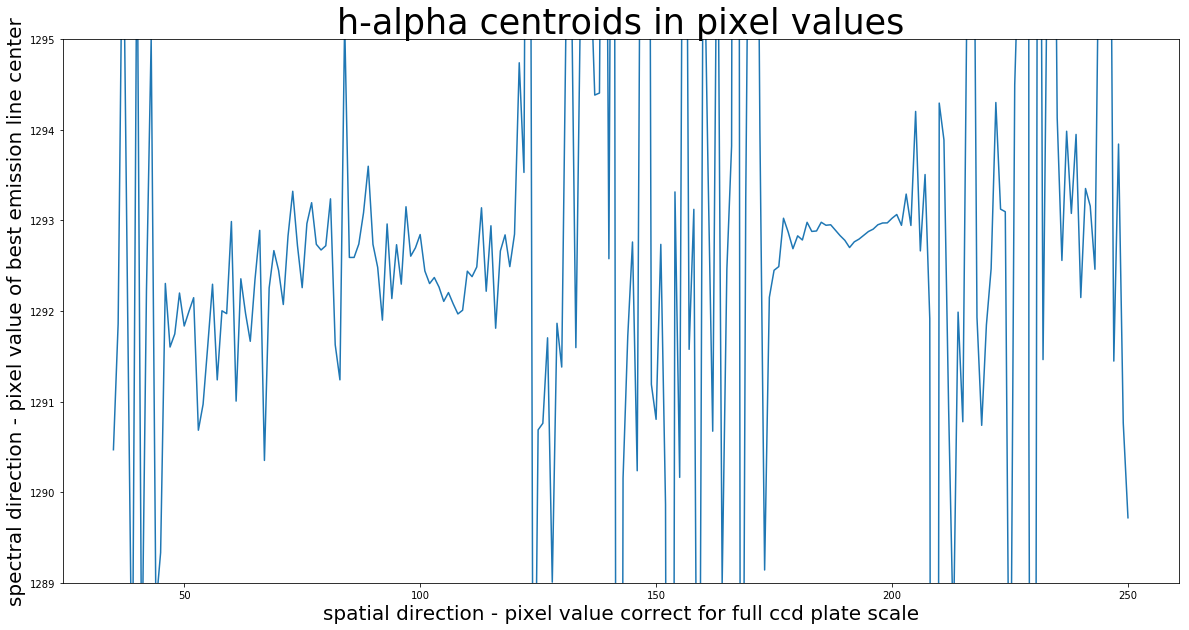

In [50]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0])))) #all rows, full ccd wl range
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1289:1297] #isolate wls around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1279:1287] #use 'bestline_range_correction' range

#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for count,row in enumerate(flux_data_short): 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row #flux values per wl in shortened target wl region, cycle goes thru each space row
    mean = centroid_xs
    #print('mean:',mean,'max:',max(y))
    if mean <=0.0:
        print('badrow:',count,'mean value:',mean, 'amplitude:',max(y))
     #   g_init = models.Gaussian1D(amplitude=max(y), mean=0, stddev=2.)
    #else:
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################
plt.ylim(1289,1295)

this shouldnt have changed in the spactial direction tho... they should both be flux_data_short, so whats going on?? Something in PART THREE aka the centroiding cell changes flux_dat_short


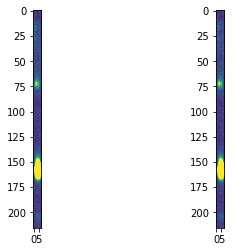

In [18]:
#my tests


#for reference
#flux_data_short = flux_data[:,1279:1287] #use 'bestline_range_correction' range
comparingthis = flux_data[:,1279:1287] #same def of flux_data_short from centroiding cell
#plt.figure(figsize=(10,10))
#plt.imshow(comparingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.imshow(flux_data_short,vmin=vmin,vmax=vmax)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(comparingthis,vmin=vmin,vmax=vmax)
ax1.imshow(flux_data_short,vmin=vmin,vmax=vmax)
print('now its doing that dumb shit where restart nb and variables change')

In [106]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i)
        badindices.append(i)
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 216 216
bad matrix at array: 3
bad matrix at array: 11
bad matrix at array: 25
bad matrix at array: 31
bad matrix at array: 34
bad matrix at array: 37
bad matrix at array: 38
bad matrix at array: 40
bad matrix at array: 41
bad matrix at array: 45
bad matrix at array: 46
bad matrix at array: 48
bad matrix at array: 51
bad matrix at array: 56
bad matrix at array: 58
bad matrix at array: 60
bad matrix at array: 61
bad matrix at array: 80
bad matrix at array: 83
bad matrix at array: 85
bad matrix at array: 97
bad matrix at array: 130
bad matrix at array: 135
bad matrix at array: 138
bad matrix at array: 182
bad matrix at array: 187
bad matrix at array: 188
bad matrix at array: 193
bad matrix at array: 197
bad matrix at array: 198
bad matrix at array: 211
number of bad fits is: 31


In [87]:
#creating  mask

maskarray = np.zeros(len(gaussian_means))
for i in badindices:
    #print(i,startingarray[i])
    maskarray[i]=1
#     #startingarray[np.where(startingarray[i]==startingarray[i])]=1 #value =1 means masked
    
maskarray.astype(np.int)
maskarray
# valarr=[]
# startingarray
# for val in startingarray:
#     if val >0:
#         valarr.append(val)
#     total = np.sum(valarr)
# total #verifys have same number of bad fits as length of badindices
x = gaussian_means
mx = ma.masked_array(x, mask=maskarray)
#print(mx)
maskarray

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

(1289, 1295)

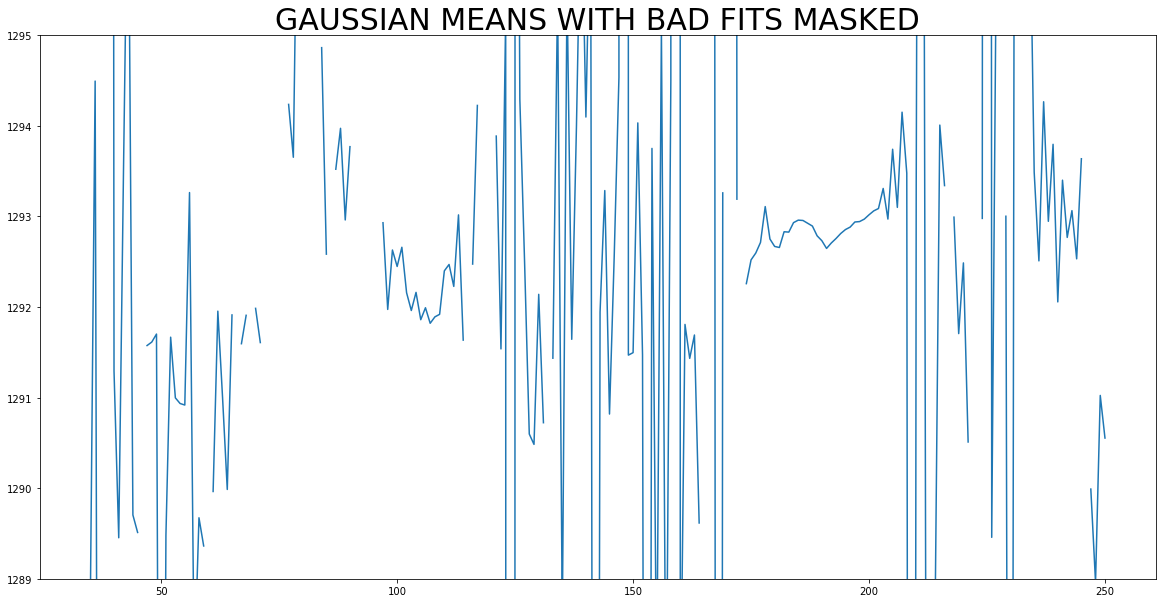

In [97]:
gaussmeans_specpix_fullccd_MASKED = mx + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = mx + stddev + wl_pix_correction + bestline_range_correction[0]



plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
#plt.ylim(1280,1300)
plt.ylim(1289,1295)


In [103]:
print(gaussmeans_specpix_fullccd_MASKED)

[1288.8434253241974 1294.4936926477117 1276.3068681929606 --
 1345.074532625987 1291.2934018141007 1289.4528248021138 1293.4741990286195
 1297.2613421683243 1289.704272894215 1289.511535887043 --
 1291.5745775953478 1291.6130528198103 1291.701198241788 1279.6394307269193
 1289.4806031090288 1291.6668367891155 1290.9971135846129
 1290.9348929849637 1290.9178730853246 1293.2631732801908
 1287.9406999032333 1289.6736113774884 1289.3624776852023 --
 1289.9637540355523 1291.9541069100485 1291.0011903550608 1289.986078172754
 1291.9123222427368 -- 1291.5949214760792 1291.908196345646 --
 1291.9850173916934 1291.6074462380782 -- -- 1293.3044785017023 -- --
 1294.236214622855 1293.6528107641404 1297.4089043979643 -- --
 1290.3575829742022 -- 1294.8625806218993 1292.583344852399 --
 1293.5207519609087 1293.9721978727393 1292.9608051616533 1293.769633514063
 -- 1291.257105245381 -- 1292.098425665877 -- -- 1292.9299765908327
 1291.9732732146306 1292.629064784824 1292.4473279155507 1292.6593628109

(1280, 1300)

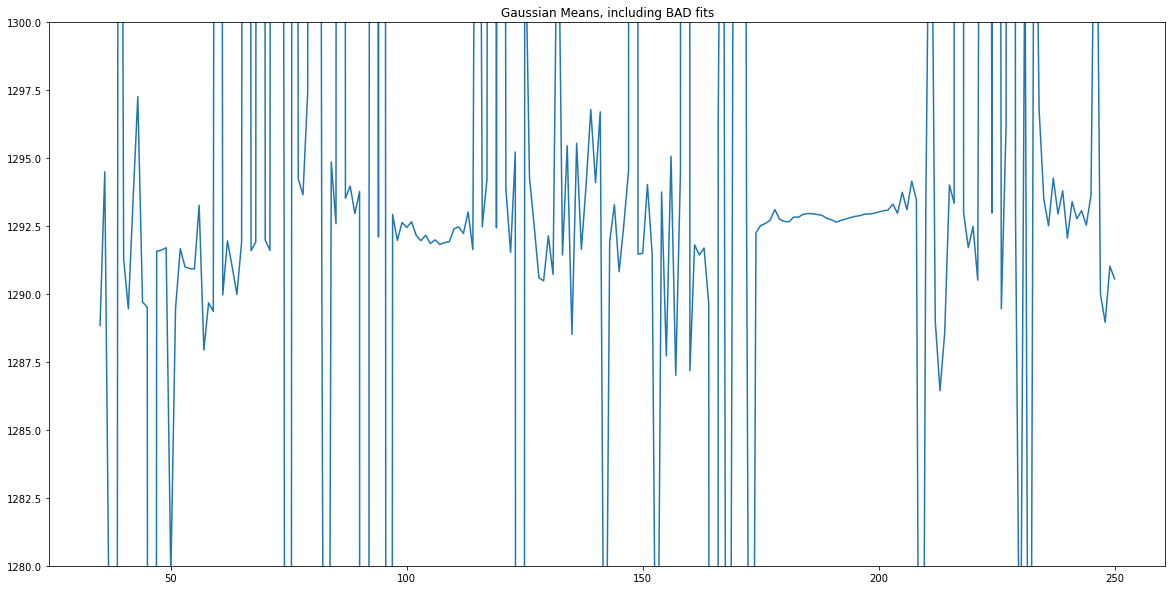

In [90]:
plt.figure(figsize=(20,10))
plt.title('Gaussian Means, including BAD fits')
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd)
plt.ylim(1280,1300)

(6600, 6655)

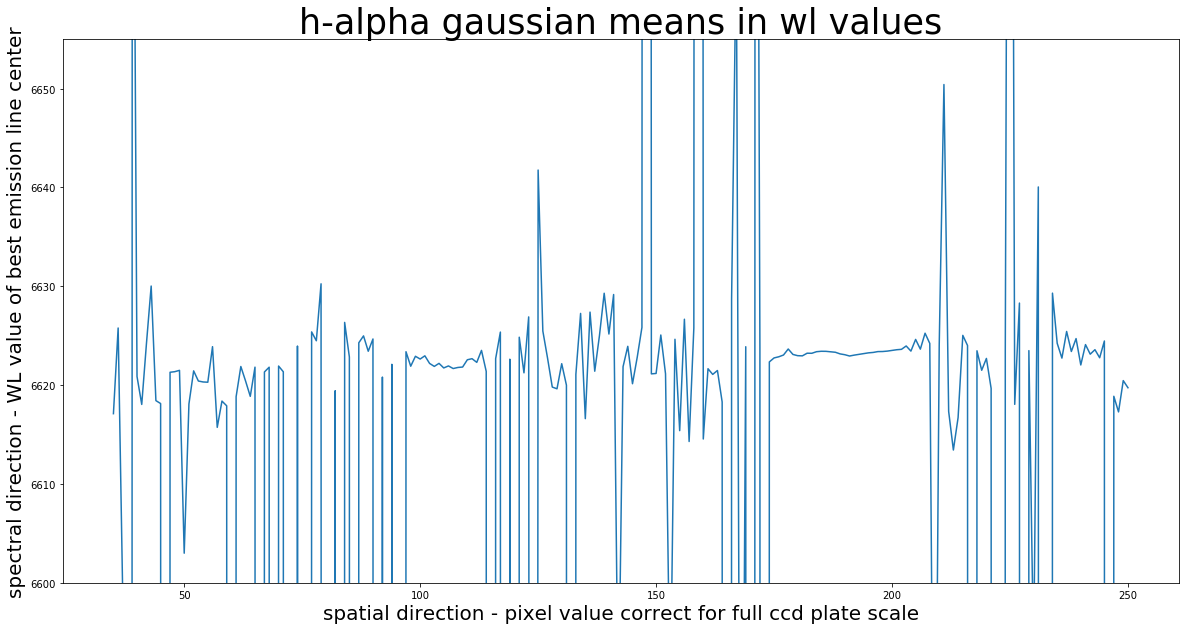

In [102]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
##########################################################
#plt.ylim(6620,6625)
plt.ylim(6600,6655)

In [105]:
wl_gaussians[2:5] #middle value (index=3)should have been masked, why wasnt it?

array([ 6597.88297098,  4656.67940813,  6703.39221108])

In [107]:
wl_gaussians[10:13] #same as above, (index=11), these all spit out same wl when should be mask

#maybe try masking corrections, create array like zeros and sum along an axis instead of stright adding


array([ 6618.13684402,  4656.67940813,  6621.30147796])